In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Activation, Dropout,Flatten,Embedding
from keras.layers import Conv1D,MaxPooling1D,GlobalAveragePooling1D, Bidirectional, LSTM, GRU
from keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD,Nadam,RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix,classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
import pickle
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Dataset Loading

In [2]:
df_train = pd.read_csv('/kaggle/input/revised-corrector-dataset/train_corr.csv')
df_test = pd.read_csv('/kaggle/input/revised-corrector-dataset/test_corr.csv')

### Train Dataset Processing

In [3]:
df_train.head()

,Unnamed: 0,Video ID,Channel name,Time of Publishing,Title,Genre,Comment,Error,Category,Correct form
0,0,bck5xK97XFI,A.U. Unique Ltd.,2021-09-17T13:15:12Z,~প্রতিটি কথা কলিজায় লাগে!!🥰||Tamil Bangla dubb...,Entertainment,সত্য কথা গুলো কলিজায় লাগে,0.0,NaN,NaN
1,1,bck5xK97XFI,A.U. Unique Ltd.,2021-09-17T13:15:12Z,~প্রতিটি কথা কলিজায় লাগে!!🥰||Tamil Bangla dubb...,Entertainment,সত্যি কথা গুলো অনেক ভালো লাগল,0.0,Spelling,সত্যি কথা গুলো অনেক ভালো লাগলো
2,2,bck5xK97XFI,A.U. Unique Ltd.,2021-09-17T13:15:12Z,~প্রতিটি কথা কলিজায় লাগে!!🥰||Tamil Bangla dubb...,Entertainment,অনেক সুন্দর অভিনয় করেন উনি আমার অনেক ভালো লাগে,0.0,NaN,NaN
3,3,bck5xK97XFI,A.U. Unique Ltd.,2021-09-17T13:15:12Z,~প্রতিটি কথা কলিজায় লাগে!!🥰||Tamil Bangla dubb...,Entertainment,আমার খুব প্রিয় লাগে আপনাকে,0.0,NaN,NaN
4,4,DBsKI0SbFLI,SOMOY TV,2023-06-27T10:39:57Z,সেই কোটিপতি এখন ফকির কেন? | Rajbari News | Lif...,News,কর্ম ভালো হওয়া উচিত ধন্যবাদ সবাইকে,0.0,NaN,NaN


In [4]:
df_train.describe()

,Unnamed: 0,Error
count,20083.000000,20083.000000
mean,10041.000000,0.619629
std,5797.607064,0.485490
min,0.000000,0.000000
25%,5020.500000,0.000000
50%,10041.000000,1.000000
75%,15061.500000,1.000000
max,20082.000000,1.000000


<AxesSubplot:xlabel='Error', ylabel='count'>

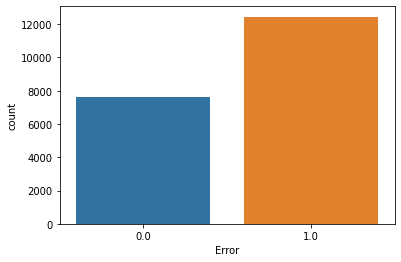

In [5]:
sns.countplot(df_train.Error)

In [6]:
df_train.isnull().sum()

Unnamed: 0               0
Video ID                 0
Channel name             0
Time of Publishing       0
Title                    0
Genre                    2
Comment                  0
Error                    0
Category              7646
Correct form          2041
dtype: int64

In [7]:
df_train.Error.value_counts()

1.0    12444
0.0     7639
Name: Error, dtype: int64

### Functions for preprocessing text 

In [8]:
def remove_pattern(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text


punc = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰✌�￰৷￰'''
def remove_punc(text):
    cleaned = ""
    for char in text:
        if char not in punc:
            cleaned += char
    return cleaned

In [ ]:
# banstop =pd.read_excel('../input/banstopwords/banstop.xlsx')
# stp_words = banstop['words'].tolist()

In [ ]:
# def remove_stopwords(text):
#     text = str(text)
#     words = text.split()
#     l = [word for word in words if word not in stp_words]
#     cleaned = ' '.join(str(x) for x in l)
#     return cleaned

In [9]:
def preprocess(text):
    cleaned = remove_punc(remove_pattern(text))
#     final = remove_stopwords(cleaned)
    return cleaned

In [10]:
df_train['cleaned'] = df_train['Comment'].apply(preprocess)
df_test['cleaned'] = df_test['Comment'].apply(preprocess)

In [11]:
df_train.head()

,Unnamed: 0,Video ID,Channel name,Time of Publishing,Title,Genre,Comment,Error,Category,Correct form,cleaned
0,0,bck5xK97XFI,A.U. Unique Ltd.,2021-09-17T13:15:12Z,~প্রতিটি কথা কলিজায় লাগে!!🥰||Tamil Bangla dubb...,Entertainment,সত্য কথা গুলো কলিজায় লাগে,0.0,NaN,NaN,সত্য কথা গুলো কলিজায় লাগে
1,1,bck5xK97XFI,A.U. Unique Ltd.,2021-09-17T13:15:12Z,~প্রতিটি কথা কলিজায় লাগে!!🥰||Tamil Bangla dubb...,Entertainment,সত্যি কথা গুলো অনেক ভালো লাগল,0.0,Spelling,সত্যি কথা গুলো অনেক ভালো লাগলো,সত্যি কথা গুলো অনেক ভালো লাগল
2,2,bck5xK97XFI,A.U. Unique Ltd.,2021-09-17T13:15:12Z,~প্রতিটি কথা কলিজায় লাগে!!🥰||Tamil Bangla dubb...,Entertainment,অনেক সুন্দর অভিনয় করেন উনি আমার অনেক ভালো লাগে,0.0,NaN,NaN,অনেক সুন্দর অভিনয় করেন উনি আমার অনেক ভালো লাগে
3,3,bck5xK97XFI,A.U. Unique Ltd.,2021-09-17T13:15:12Z,~প্রতিটি কথা কলিজায় লাগে!!🥰||Tamil Bangla dubb...,Entertainment,আমার খুব প্রিয় লাগে আপনাকে,0.0,NaN,NaN,আমার খুব প্রিয় লাগে আপনাকে
4,4,DBsKI0SbFLI,SOMOY TV,2023-06-27T10:39:57Z,সেই কোটিপতি এখন ফকির কেন? | Rajbari News | Lif...,News,কর্ম ভালো হওয়া উচিত ধন্যবাদ সবাইকে,0.0,NaN,NaN,কর্ম ভালো হওয়া উচিত ধন্যবাদ সবাইকে


### Removing low length data 

In [ ]:
# df_train['length'] = df_train['cleaned'].str.split().str.len()
# df_train = df_train.loc[df_train['length']>=2]

### Train Dataset summary

In [12]:
def show_summary(dataset):

    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.Error.value_counts().to_dict().items()]
  # find word list
    for label in class_label:
        word_list = [word.strip().lower() for t in list(dataset[dataset.Error==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.Error==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of Headlines:{}".format(len(list(dataset[dataset.Error==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return documents,words,u_words,class_label

documents,words,u_words,class_names = show_summary(df_train)


Class Name :  1.0
Number of Headlines:12444
Number of Words:178052
Number of Unique Words:24594
Most Frequent Words:

না	2464
এই	2232
অনেক	1573
করে	1469
ভালো	1412
আমার	1361
আর	1246
আমি	1233
জন্য	1212
কে	967

Class Name :  0.0
Number of Headlines:7639
Number of Words:80798
Number of Unique Words:10824
Most Frequent Words:

না	1070
এই	1026
অনেক	945
ভালো	901
আমার	679
আল্লাহ	643
জন্য	635
সুন্দর	615
করে	559
আমাদের	557
Total Number of Unique Words:28615


### Frequency length distribution

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(df_train.Error)
Test_Y = Encoder.fit_transform(df_test.Error)
df_all  = pd.concat([df_train, df_test], ignore_index=True)
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df_all['cleaned'])
Train_X_Tfidf = Tfidf_vect.transform(df_train['cleaned'])
Test_X_Tfidf = Tfidf_vect.transform(df_test['cleaned'])


In [ ]:
# model = RandomForestClassifier(
#     n_estimators=100,    # Number of decision trees in the forest
#     max_depth=None,       # Maximum depth of individual trees
#     min_samples_split=2,  # Minimum number of samples required to split an internal node
#     min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node
#     random_state=42
# )
model = RandomForestClassifier(random_state=42)


In [ ]:

model.fit(Train_X_Tfidf, Train_Y)
y_pred = model.predict(Test_X_Tfidf)

In [ ]:
print(metrics.classification_report(Test_Y, y_pred,digits = 4))

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Create the grid search
# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')

# # Fit the grid search to the data
# grid_search.fit(Train_X_Tfidf, Train_Y)

# # Print the best parameters
# print("Best Parameters:", grid_search.best_params_)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

# Best Parameters
best_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

# Create and train the RandomForestClassifier with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(Train_X_Tfidf, Train_Y)

# Transform the test data using the same vectorizer as in training
Test_X_Tfidf = Tfidf_vect.transform(df_test['cleaned'])

# Make predictions
# predictions_RF = best_model.predict(Test_X_Tfidf)

# Create an AdaBoostClassifier with base_estimator as the RandomForestClassifier with best parameters
ada_model = AdaBoostClassifier(base_estimator=best_model, n_estimators=50, learning_rate=1.0)
ada_model.fit(Train_X_Tfidf, Train_Y)

# Make predictions
y_pred_ada = ada_model.predict(Test_X_Tfidf)

# Evaluate performance
print("AdaBoost Accuracy:", accuracy_score(Test_Y, y_pred_ada))
# Evaluate performance



AdaBoost Accuracy: 0.6093189964157706


In [15]:
print(metrics.classification_report(Test_Y, y_pred_ada, digits=4))

              precision    recall  f1-score   support

           0     0.4818    0.3597    0.4119      1910
           1     0.6599    0.7625    0.7075      3112

    accuracy                         0.6093      5022
   macro avg     0.5708    0.5611    0.5597      5022
weighted avg     0.5922    0.6093    0.5951      5022



### Tokenizing text